# Feature Engineering

In [36]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV, ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
%matplotlib inline


In [37]:
# import the csv file
train = pd.read_csv("../datasets/train_final.csv", na_filter=False)
test = pd.read_csv("../datasets/test_final.csv", na_filter=False)

In [38]:
# Since square foot of total basement and 1st floor are highly correlated
# instead of removing one of the variable
# combine all the area and call the variable Total Area
# make a new feature by multiplying total area with overall quality
train['Total Area'] = train['Total Bsmt SF'] + train['1st Flr SF'] + train['2nd Flr SF']
train.drop(['Total Bsmt SF', '1st Flr SF', '2nd Flr SF'], axis = 1, inplace=True)
train['Total Area * Overall'] = train['Total Area'] * train['Overall Qual']
train['Gr Liv Area * Overall'] = train['Gr Liv Area'] * train['Overall Qual']

test['Total Area'] = test['Total Bsmt SF'] + test['1st Flr SF'] + test['2nd Flr SF']
test.drop(['Total Bsmt SF', '1st Flr SF', '2nd Flr SF'], axis = 1, inplace=True)
test['Total Area * Overall'] = test['Total Area'] * test['Overall Qual']
test['Gr Liv Area * Overall'] = test['Gr Liv Area'] * test['Overall Qual']

In [39]:
# Check the dataset
train['Neighborhood'].value_counts()

NAmes      310
CollgCr    180
OldTown    163
Edwards    143
Somerst    130
NridgHt    122
Gilbert    116
Sawyer     111
SawyerW     87
NWAmes      87
Mitchel     82
BrkSide     76
Crawfor     71
IDOTRR      69
Timber      48
NoRidge     48
StoneBr     38
SWISU       32
ClearCr     27
MeadowV     24
Blmngtn     22
BrDale      19
NPkVill     17
Veenker     17
Blueste      6
Greens       3
GrnHill      2
Landmrk      1
Name: Neighborhood, dtype: int64

In [40]:
train.loc[:10,['Total Area * Overall']]

,Total Area * Overall
0,13224.0
1,21245.0
2,10570.0
3,9140.0
4,12726.0
5,20430.0
6,9714.0
7,11880.0
8,9240.0
9,15600.0


# Setting Feature and Target

In [41]:
# Setup the X and the y for modeling
features = ['MS SubClass', 'Lot Frontage', 'Lot Area', 'Street', 'Alley',
       'Lot Shape', 'Land Slope', 'Overall Qual', 'Overall Cond', 'Year Built',
       'Year Remod/Add', 'Mas Vnr Area', 'Exter Qual', 'Exter Cond',
       'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1',
       'BsmtFin SF 1', 'BsmtFin Type 2', 'BsmtFin SF 2', 'Bsmt Unf SF',
       'Heating QC', 'Central Air', 'Low Qual Fin SF', 'Gr Liv Area',
       'Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath', 'Half Bath',
       'Bedroom AbvGr', 'Kitchen AbvGr', 'Kitchen Qual', 'TotRms AbvGrd',
       'Fireplaces', 'Garage Yr Blt', 'Garage Finish', 'Garage Area',
       'Paved Drive', 'Wood Deck SF', 'Open Porch SF', 'Enclosed Porch',
       '3Ssn Porch', 'Screen Porch', 'Pool Area', 'Fence', 'Misc Val',
       'Mo Sold', 'Yr Sold', 'Total Area','Total Area * Overall',
            'MS Zoning', 'Land Contour', 'Utilities', 'Lot Config', 'Neighborhood',
       'Condition 1', 'Condition 2', 'Bldg Type', 'House Style', 'Roof Style',
       'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type',
       'Foundation', 'Heating', 'Electrical', 'Functional', 'Garage Type',
       'Misc Feature', 'Sale Type']
X = train[features]
y = train['SalePrice']

# Dummy Columns

In [42]:
train_cat = X.select_dtypes(exclude=['number'])
train_num = X.select_dtypes(include=['number'])

In [43]:
train_cat_dm = pd.DataFrame(pd.get_dummies(train_cat), index = train_cat.index)

In [44]:
X_combine = pd.concat([train_num, train_cat_dm], axis = 1)
X_combine.head()

,MS SubClass,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Slope,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,Exter Qual,Exter Cond,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Heating QC,Central Air,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Fireplaces,Garage Yr Blt,Garage Finish,Garage Area,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Fence,Misc Val,Mo Sold,Yr Sold,Total Area,Total Area * Overall,MS Zoning_A (agr),MS Zoning_C (all),MS Zoning_FV,MS Zoning_I (all),MS Zoning_RH,MS Zoning_RL,MS Zoning_RM,Land Contour_Bnk,Land Contour_HLS,Land Contour_Low,Land Contour_Lvl,Utilities_AllPub,Utilities_NoSeWa,Utilities_NoSewr,Lot Config_Corner,Lot Config_CulDSac,Lot Config_FR2,Lot Config_FR3,Lot Config_Inside,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_Greens,Neighborhood_GrnHill,Neighborhood_IDOTRR,Neighborhood_Landmrk,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition 1_Artery,Condition 1_Feedr,Condition 1_Norm,Condition 1_PosA,Condition 1_PosN,Condition 1_RRAe,Condition 1_RRAn,Condition 1_RRNe,Condition 1_RRNn,Condition 2_Artery,Condition 2_Feedr,Condition 2_Norm,Condition 2_PosA,Condition 2_PosN,Condition 2_RRAe,Condition 2_RRAn,Condition 2_RRNn,Bldg Type_1Fam,Bldg Type_2fmCon,Bldg Type_Duplex,Bldg Type_Twnhs,Bldg Type_TwnhsE,House Style_1.5Fin,House Style_1.5Unf,House Style_1Story,House Style_2.5Fin,House Style_2.5Unf,House Style_2Story,House Style_SFoyer,House Style_SLvl,Roof Style_Flat,Roof Style_Gable,Roof Style_Gambrel,Roof Style_Hip,Roof Style_Mansard,Roof Style_Shed,Roof Matl_ClyTile,Roof Matl_CompShg,Roof Matl_Membran,Roof Matl_Tar&Grv,Roof Matl_WdShake,Roof Matl_WdShngl,Exterior 1st_AsbShng,Exterior 1st_AsphShn,Exterior 1st_BrkComm,Exterior 1st_BrkFace,Exterior 1st_CBlock,Exterior 1st_CemntBd,Exterior 1st_HdBoard,Exterior 1st_ImStucc,Exterior 1st_MetalSd,Exterior 1st_Plywood,Exterior 1st_Stone,Exterior 1st_Stucco,Exterior 1st_VinylSd,Exterior 1st_Wd Sdng,Exterior 1st_WdShing,Exterior 2nd_AsbShng,Exterior 2nd_AsphShn,Exterior 2nd_Brk Cmn,Exterior 2nd_BrkFace,Exterior 2nd_CBlock,Exterior 2nd_CmentBd,Exterior 2nd_HdBoard,Exterior 2nd_ImStucc,Exterior 2nd_MetalSd,Exterior 2nd_Plywood,Exterior 2nd_Stone,Exterior 2nd_Stucco,Exterior 2nd_VinylSd,Exterior 2nd_Wd Sdng,Exterior 2nd_Wd Shng,Mas Vnr Type_BrkCmn,Mas Vnr Type_BrkFace,Mas Vnr Type_NA,Mas Vnr Type_None,Mas Vnr Type_Stone,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sal,Functional_Sev,Functional_Typ,Garage Type_2Types,Garage Type_Attchd,Garage Type_Basment,Garage Type_BuiltIn,Garage Type_CarPort,Garage Type_Detchd,Garage Type_NA,Misc Feature_Elev,Misc Feature_Gar2,Misc Feature_NA,Misc Feature_Othr,Misc Feature_Shed,Misc Feature_TenC,Sale Type_COD,Sale Type_CWD,Sale Type_Con,Sale Type_ConLD,Sale Type_ConLI,Sale Type_ConLw,Sale Type_New,Sale Type_Oth,Sale Type_WD
0,60,0.0,13517,1,0,2,2,6,8,1976,2005,289.0,4,3,3,3,1,6,533.0,1,0.0,192.0,5,1,0,1479,0.0,0.0,2,1,3,1,4,6,0,1976.0,2,475.0,2,0,44,0,0,0,0,0,0,3,2010,2204.0,13224.0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,

# Train/Test Split

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X_combine, y, test_size = 0.33, random_state = 85)

# Standardizing Numerical Predictors

In [46]:
num_col = train_num.columns.tolist()
cat_col = train_cat_dm.columns.tolist()
train_num = X_train[num_col]
train_cat = X_train[cat_col]
test_num = X_test[num_col]
test_cat = X_test[cat_col]

In [47]:
# Instantiate Standard Scaler.
ss = StandardScaler()

# Fit Standard Scaler to data.
ss.fit(train_num)

# Transform data using Standard Scaler.
train_num_sc = pd.DataFrame(ss.transform(train_num), columns = train_num.columns, index=train_num.index)
test_num_sc = pd.DataFrame(ss.transform(test_num), columns = test_num.columns, index=test_num.index)
train_num_sc.head()

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  if __name__ == '__main__':


,MS SubClass,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Slope,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,Exter Qual,Exter Cond,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Heating QC,Central Air,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Fireplaces,Garage Yr Blt,Garage Finish,Garage Area,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Fence,Misc Val,Mo Sold,Yr Sold,Total Area,Total Area * Overall
350,-0.153974,-0.239673,-0.579999,0.060434,-0.268618,0.70542,0.214206,-0.068311,0.372498,-0.997964,-1.598114,-0.565375,-0.677971,2.414100,-0.541367,0.131720,-0.578387,-0.690278,-0.347089,-0.284491,-0.284329,-0.608753,0.877444,0.281674,-0.116064,-0.604707,-0.795941,3.649641,-1.027731,1.252052,0.181018,-0.201389,-0.763346,-0.280104,2.195967,0.232755,-0.779758,0.515188,0.322181,-0.751174,-0.700372,-0.388202,-0.087472,-0.280273,-0.056174,-0.476876,-0.092166,-1.158339,1.720765,-0.969700,-0.670342
1158,-0.867502,1.028573,0.248831,0.060434,-0.268618,0.70542,0.214206,2.081153,-0.534971,1.208524,1.140156,2.713144,1.059962,-0.228907,0.583955,0.131720,2.239712,1.190617,3.642467,-0.284491,-0.284329,-0.882893,0.877444,0.281674,-0.116064,1.628734,1.115988,-0.249742,0.794337,-0.734460,0.181018,-0.201389,2.290038,0.382310,2.195967,0.309572,0.332794,4.129699,0.322181,-0.751174,-0.700372,0.746429,-0.087472,4.400787,-0.056174,-0.476876,-0.092166,-0.066985,0.181487,2.564645,3.003058
609,0.083868,1.585364,0.589658,0.060434,-0.268618,0.70542,0.214206,0.648177,-0.534971,1.143628,1.045732,1.505891,1.059962,-0.228907,1.709278,1.906061,-0.578387,-1.160501,-0.925476,-0.284491,-0.284329,1.087767,0.877444,0.281674,-0.116064,1.413662,-0.795941,-0.249742,0.794337,1.252052,0.181018,-0.201389,0.763346,1.707138,0.642281,0.305182,0.332794,2.252213,0.322181,0.792365,0.228240,-0.388202,-0.087472,-0.280273,-0.056174,-0.476876,-0.092166,0.660584,-0.588152,0.896037,0.788234
2030,-0.153974,0.255252,-0.190974,0.060434,4.966579,0.70542,-3.873559,-1.501287,1.279967,-2.295899,-1.598114,-0.565375,-0.677971,-0.228907,-0.541367,0.131720,0.360979,-1.160501,-0.925476,-0.284491,-0.284329,0.629369,-0.159192,0.281674,-0.116064,-0.641931,-0.795941,-0.249742,-1.027731,-0.734460,-1.050262,-0.201389,-0.763346,0.382310,-0.911406,0.213002,0.332794,-0.383758,-3.321250,-0.204504,-0.700372,1.200281,-0.087472,-0.280273,-0.056174,-0.476876,-0.092166,-1.885908,1.720765,-0.627585,-0.968431
93,0.797395,0.193386,-0.433971,0.060434,-0.268618,0.70542,0.214206,-0.784799,-0.534971,0.267522,-0.228979,-0.565375,-0.677971,-0.228907,-3.917333,-5.191303,-1.517754,-1.630725,-0.925476,-1.310449,-0.284329,-1.300843,-1.195829,0.281674,-0.116064,0.096346,-0.795941,-0.249742,0.794337,-0.734460,1.412298,4.488577,-0.763346,1.044724,-0.911406,0.245923,-0.779758,-0.308846,0.322181,-0.751174,-0.700372,-0.388202,-0.087472,-0.280273,-0.056174,2.853377,-0.092166,-0.066985,0.951126,-1.266031,-1.025746


In [48]:
## combine two dataframe
train_combine = pd.concat([train_num_sc, train_cat], axis = 1)
test_combine = pd.concat([test_num_sc, test_cat], axis = 1)
train_combine.head()

,MS SubClass,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Slope,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,Exter Qual,Exter Cond,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Heating QC,Central Air,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Fireplaces,Garage Yr Blt,Garage Finish,Garage Area,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Fence,Misc Val,Mo Sold,Yr Sold,Total Area,Total Area * Overall,MS Zoning_A (agr),MS Zoning_C (all),MS Zoning_FV,MS Zoning_I (all),MS Zoning_RH,MS Zoning_RL,MS Zoning_RM,Land Contour_Bnk,Land Contour_HLS,Land Contour_Low,Land Contour_Lvl,Utilities_AllPub,Utilities_NoSeWa,Utilities_NoSewr,Lot Config_Corner,Lot Config_CulDSac,Lot Config_FR2,Lot Config_FR3,Lot Config_Inside,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_Greens,Neighborhood_GrnHill,Neighborhood_IDOTRR,Neighborhood_Landmrk,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition 1_Artery,Condition 1_Feedr,Condition 1_Norm,Condition 1_PosA,Condition 1_PosN,Condition 1_RRAe,Condition 1_RRAn,Condition 1_RRNe,Condition 1_RRNn,Condition 2_Artery,Condition 2_Feedr,Condition 2_Norm,Condition 2_PosA,Condition 2_PosN,Condition 2_RRAe,Condition 2_RRAn,Condition 2_RRNn,Bldg Type_1Fam,Bldg Type_2fmCon,Bldg Type_Duplex,Bldg Type_Twnhs,Bldg Type_TwnhsE,House Style_1.5Fin,House Style_1.5Unf,House Style_1Story,House Style_2.5Fin,House Style_2.5Unf,House Style_2Story,House Style_SFoyer,House Style_SLvl,Roof Style_Flat,Roof Style_Gable,Roof Style_Gambrel,Roof Style_Hip,Roof Style_Mansard,Roof Style_Shed,Roof Matl_ClyTile,Roof Matl_CompShg,Roof Matl_Membran,Roof Matl_Tar&Grv,Roof Matl_WdShake,Roof Matl_WdShngl,Exterior 1st_AsbShng,Exterior 1st_AsphShn,Exterior 1st_BrkComm,Exterior 1st_BrkFace,Exterior 1st_CBlock,Exterior 1st_CemntBd,Exterior 1st_HdBoard,Exterior 1st_ImStucc,Exterior 1st_MetalSd,Exterior 1st_Plywood,Exterior 1st_Stone,Exterior 1st_Stucco,Exterior 1st_VinylSd,Exterior 1st_Wd Sdng,Exterior 1st_WdShing,Exterior 2nd_AsbShng,Exterior 2nd_AsphShn,Exterior 2nd_Brk Cmn,Exterior 2nd_BrkFace,Exterior 2nd_CBlock,Exterior 2nd_CmentBd,Exterior 2nd_HdBoard,Exterior 2nd_ImStucc,Exterior 2nd_MetalSd,Exterior 2nd_Plywood,Exterior 2nd_Stone,Exterior 2nd_Stucco,Exterior 2nd_VinylSd,Exterior 2nd_Wd Sdng,Exterior 2nd_Wd Shng,Mas Vnr Type_BrkCmn,Mas Vnr Type_BrkFace,Mas Vnr Type_NA,Mas Vnr Type_None,Mas Vnr Type_Stone,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sal,Functional_Sev,Functional_Typ,Garage Type_2Types,Garage Type_Attchd,Garage Type_Basment,Garage Type_BuiltIn,Garage Type_CarPort,Garage Type_Detchd,Garage Type_NA,Misc Feature_Elev,Misc Feature_Gar2,Misc Feature_NA,Misc Feature_Othr,Misc Feature_Shed,Misc Feature_TenC,Sale Type_COD,Sale Type_CWD,Sale Type_Con,Sale Type_ConLD,Sale Type_ConLI,Sale Type_ConLw,Sale Type_New,Sale Type_Oth,Sale Type_WD
350,-0.153974,-0.239673,-0.579999,0.060434,-0.268618,0.70542,0.214206,-0.068311,0.372498,-0.997964,-1.598114,-0.565375,-0.677971,2.414100,-0.541367,0.131720,-0.578387,-0.690278,-0.347089,-0.284491,-0.284329,-0.608753,0.877444,0.281674,-0.116064,-0.604707,-0.795941,3.649641,-1.027731,1.252052,0.18101

In [49]:
# check the shape of the datasets
print(train_combine.shape)
print(test_combine.shape)

(1374, 221)
(677, 221)


# Cross-Validating with all columns

In [50]:
# Cross validate lasso regression
lasso = LassoCV()
lasso_scores = cross_val_score(lasso, train_combine, np.log(y_train), cv = 5)
lasso_model = lasso.fit(train_combine, np.log(y_train))
lasso_scores.mean()

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The defaul

0.8576077663475244

In [51]:
# Cross validate elastic net regression
elastic = ElasticNetCV()
elastic_scores = cross_val_score(elastic, train_combine, np.log(y_train), cv=5)
elastic_scores.mean()

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The defaul

0.8532335566786193

# Selecting the Significant Features

In [52]:
# Pull out coefficent of lasso regression
coefs = pd.Series(lasso_model.coef_,index=train_combine.columns)
coef_table = pd.DataFrame(list(zip(train_combine.columns.tolist(),lasso.coef_.tolist())), 
             columns=['Features', 'coef'])

In [53]:
# Make a function that uses different cutoff and collect the r^2 score for train/test and RMSE
def feature_select():
    cut_off = np.arange(0, 0.035, 0.005)
    n = []
    tr_score_ls = []
    ts_score_ls = []
    error_ls = []
    tr_score_en = []
    ts_score_en = []
    error_en = []
    for i in cut_off:
        imp_feat = coef_table[coef_table['coef'].abs() > i]
        n.append(len(imp_feat))
        tr = train_combine[imp_feat['Features'].tolist()]
        ts = test_combine[imp_feat['Features'].tolist()]
        
        lasso = LassoCV(cv = 5)
        lasso_model = lasso.fit(tr, np.log(y_train))
        tr_score_ls.append(lasso_model.score(tr, np.log(y_train)))
        ts_score_ls.append(lasso_model.score(ts, np.log(y_test)))
        pred_ls = lasso_model.predict(ts)
        error_ls.append(np.sqrt(mean_squared_error(y_test, np.exp(pred_ls))))
        
        elastic = ElasticNetCV(cv = 5)
        elastic_model = elastic.fit(tr, np.log(y_train))
        tr_score_en.append(elastic_model.score(tr, np.log(y_train)))
        ts_score_en.append(elastic_model.score(ts, np.log(y_test)))
        pred_en = elastic_model.predict(ts)
        error_en.append(np.sqrt(mean_squared_error(y_test, np.exp(pred_en))))
    table = pd.DataFrame({'Cutoff': cut_off,
                          'Features': n, 
                          'Train Score (Lasso)': tr_score_ls, 
                          'Test Score (Lasso)': ts_score_ls,
                          'Train Score (Enet)': tr_score_en, 
                          'Test Score (Enet)': ts_score_en,
                         'RMSE (Lasso)': error_ls,
                         'RMSE (Enet)': error_en})
    return(table)

In [54]:
table = feature_select()
table

,Cutoff,Features,Train Score (Lasso),Test Score (Lasso),Train Score (Enet),Test Score (Enet),RMSE (Lasso),RMSE (Enet)
0,0.000,116,0.925591,0.891816,0.920024,0.895131,50793.401202,41506.945412
1,0.005,90,0.924915,0.898071,0.919249,0.901762,43283.639168,35606.683601
2,0.010,75,0.923362,0.899062,0.917323,0.902748,43115.793564,35298.090603
3,0.015,53,0.916320,0.894576,0.909475,0.902751,43980.827539,35467.373721
4,0.020,41,0.904083,0.880146,0.896757,0.890135,46906.344233,37474.247911
5,0.025,34,0.888060,0.862429,0.880191,0.873257,55830.605932,43425.506690
6,0.030,30,0.887432,0.862848,0.879618,0.873580,55591.405033,43316.807708
7,0.035,27,0.883527,0.861202,0.875664,0.871394,57348.308037,44456.496677


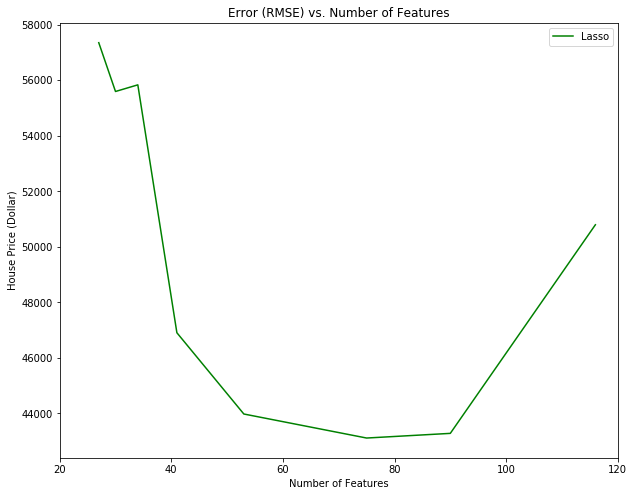

In [55]:
plt.figure(figsize = (10,8))
plt.plot(table['Features'], table['RMSE (Lasso)'], label = 'Lasso', color = 'green')
plt.xlim(20, 120)
plt.xlabel("Number of Features")
plt.ylabel("House Price (Dollar)")
plt.title("Error (RMSE) vs. Number of Features")
plt.legend();

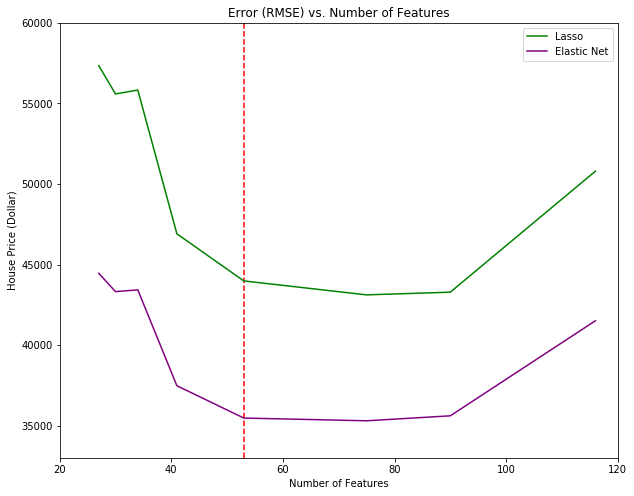

In [56]:
plt.figure(figsize = (10,8))
plt.plot(table['Features'], table['RMSE (Lasso)'], label = 'Lasso', color = 'green')
plt.plot(table['Features'], table['RMSE (Enet)'], label = 'Elastic Net', color = 'purple')
plt.ylim(33000, 60000)
plt.xlim(20, 120)
plt.xlabel("Number of Features")
plt.ylabel("House Price (Dollar)")
plt.title("Error (RMSE) vs. Number of Features")
plt.vlines(x = table['Features'][3], ymin=33000, ymax=60000,colors='r', linestyles='--')
plt.legend();

In [57]:
# Pull out columns that has coefficient of 0.015 greater.
imp_feat = coef_table[coef_table['coef'].abs() > 0.015]

In [58]:
# Check the number of columns
len(imp_feat)

53

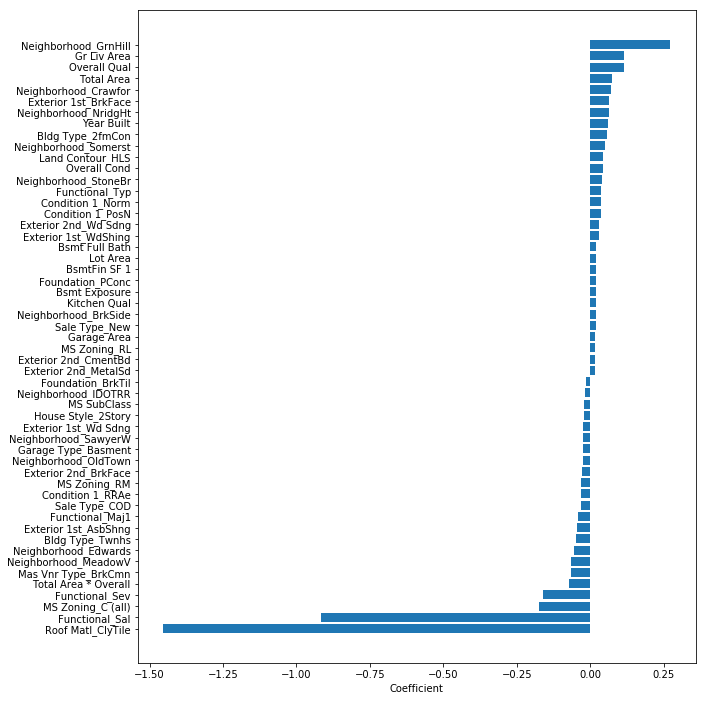

In [59]:
# Make a horizontal bar graph to visualize the coefficient
imp_feat = imp_feat.sort_values(['coef'],ascending = True).reset_index(drop=True)
plt.figure(figsize = (10,12))
plt.barh(imp_feat['Features'], imp_feat['coef'].sort_values(ascending = True))
plt.xlabel("Coefficient")
plt.style.use('seaborn-notebook');

In [60]:
# Select the columns and make a new data frame
selected_tr = train_combine[imp_feat['Features'].tolist()]
selected_ts = test_combine[imp_feat['Features'].tolist()]

# Check the Error (RMSE) with Elastic Net model

In [61]:
# Cross validate elastic regression
elastic2 = ElasticNetCV()
elastic_scores2 = cross_val_score(elastic2, selected_tr, np.log(y_train), cv=5)
elastic_scores2.mean()

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The defaul

0.8604388904640643

In [62]:
# fit the model into new regression and compare R_square scores
lasso2 = LassoCV()
lasso_model2 = lasso2.fit(selected_tr, np.log(y_train))
print(lasso_model2.score(selected_tr, np.log(y_train)))
print(lasso_model2.score(selected_ts, np.log(y_test)))

0.9163310434625052
0.894471508442104


/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


In [63]:
# fit the model into new regression and compare R_square scores
elastic_model2 = elastic2.fit(selected_tr, np.log(y_train))
print(elastic_model2.score(selected_tr, np.log(y_train)))
print(elastic_model2.score(selected_ts, np.log(y_test)))

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


0.9094750996514258
0.9027526487632476


In [64]:
# Check the Root mean square error
pred = elastic_model2.predict(selected_ts)
np.sqrt(mean_squared_error(y_test, np.exp(pred)))

35467.47600633597

In [71]:
final = {'Model': 'Elastic Net',
        'Train Score (R^2)': elastic_model2.score(selected_tr, np.log(y_train)),
        'Test Score (R^2)': elastic_model2.score(selected_ts, np.log(y_test)),
        'Error (RMSE)': np.sqrt(mean_squared_error(y_test, np.exp(pred)))}
pd.DataFrame(final, index = range(0,1))

,Model,Train Score (R^2),Test Score (R^2),Error (RMSE)
0,Elastic Net,0.909475,0.902753,35467.476006


# Tuning the Final Model

In [33]:
# initiate elastic net regression
enet = ElasticNet()

In [34]:
# Setup the parameter for tuning
param = {
    'alpha': np.arange(0.0015, 0.003, 0.0005),
    'l1_ratio': np.arange(0.1, 1.0, 0.1)
}

In [35]:
# Grid search
ran = GridSearchCV(enet, param, cv = 5, verbose=1)

In [36]:
# Fit the grid search 
ran.fit(selected_tr, np.log(y_train))

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 135 out of 135 | elapsed:    1.4s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'alpha': array([0.0015, 0.002 , 0.0025]), 'l1_ratio': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [37]:
# check the R_squared score for train
ran.best_estimator_.score(selected_tr, np.log(y_train))

0.9048477492204317

In [38]:
# check the R_squared score for test
ran.best_estimator_.score(selected_ts, np.log(y_test))

0.9041046344187711

In [39]:
# Check the Root mean squared error
pred = ran.best_estimator_.predict(selected_ts)
np.sqrt(mean_squared_error(np.log(y_test), pred))

0.13338254938077806

# Prediction for Kaggle

In [40]:
# Setup the features for the test data and split by numeric and categorical
# Make the dummy columns for categorical columns
test_features = test[features]
test_cat = test_features.select_dtypes(exclude=['number'])
test_num = test_features.select_dtypes(include=['number'])
test_cat_dm = pd.DataFrame(pd.get_dummies(test_cat), index = test_cat.index)

In [41]:
# Check if the number of train dummy columns is the same as test dummy columns
# if the dummy columns do not match, make a dummy column with the missing column and fill with zero
for col in train_cat_dm.columns:
    if col not in test_cat_dm.columns:
        test_cat_dm[col] = 0

In [42]:
# Scale the numeric columns and combine with dummy columns
X_test_sc = pd.DataFrame(ss.transform(test_num), columns = test_num.columns)
combine = pd.concat([X_test_sc, test_cat_dm], axis = 1)
combine.shape

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  


(879, 229)

In [43]:
# select the same features we picked in the train model and check the shape
final = combine[imp_feat['Features'].tolist()]
final.shape

(879, 53)

In [44]:
# Get the prediction
pred = elastic_model2.predict(final)

In [45]:
# Make a dataframe with predicted Sale Price with corresponding IDs.
predict = pred.tolist()
ident = test['Id']
result = pd.DataFrame({'Id': ident, 'SalePrice': np.exp(pred)})
result.to_csv("../datasets/result.csv",index=False)